In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import yt
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
from matplotlib.colors import LogNorm
import os,sys

from galaxy_analysis.static_data import SOLAR_ABUNDANCE

# galaxy analysis methods (for comparison)
from galaxy_analysis.gizmo import yield_model
from galaxy_analysis.utilities import cy_convert_abundances as ca
from galaxy_analysis.plot.plot_styles import *
#--------------
import copy
# gizmo analysis methods 
import gizmo_analysis as gizmo
import utilities as gizmo_ut
from utilities.basic.binning import BinClass

#------------------------------
input_type = 'mass'

def plot_settings():
    fsize = 21
    rc('text',usetex=False)
    rc('font',size=fsize)
    return

plot_settings()

In [2]:
simulation = 'm12q_res57000_nugrid'
outdir = './' + simulation + '/'
if not os.path.isdir(outdir):
    os.mkdir(outdir)

wdir = "/home/aemerick/work/gizmo_runs/m12q_res57000_nugrid/" # m12q_res5700_test/"

initial_part = gizmo.io.Read.read_snapshots(['gas'],'index',0,simulation_directory=wdir)
initial = {}
for e in ['H','He','C','N','O','Ne','Mg','Si','S','Ca','Fe']:
    initial[str.lower(e)] = np.average(initial_part['gas'].prop('massfraction.' + str.lower(e)))
initial['metals'] = np.average(initial_part['gas'].prop('massfraction.metals'))
#
#
#
#
#
    
    
sim_index = 149

# load the data set
part = gizmo.io.Read.read_snapshots(['star'], 'index', sim_index,
                                    #assign_host_principal_axes=True, 
                                    simulation_directory = wdir)

z_solar_fire   = 0.02
z_solar_nugrid = 0.0245

z_fraction     = 0.02

FIRE2_models = {}
FIRE2_yield_tables = {}
fire_part = {}
for z in [0.0001, 0.001, 0.01, 0.02]:
    fire_part[z] = copy.deepcopy(part)
    
    FIRE2_models[z] =  gizmo.agetracers.FIRE2_yields(model_Z = z / z_solar_fire, Z_scaling = True)
    FIRE2_yield_tables[z] =  gizmo.agetracers.construct_yield_table(FIRE2_models[z], 
                                                                    fire_part[z].ageprop.age_bins/1000.0)

    fire_part[z].set_yield_table(FIRE2_yield_tables[z], FIRE2_models[z].elements)
    fire_part[z].set_initial_abundances(initial)


NuGrid_models = {}
NuGrid_yield_tables = {}
nugrid_part = {}
for z in [0.0001,0.001,0.01,0.02]:
    
    nugrid_part[z] = copy.deepcopy(part)
    
    NuGrid_models[z] = gizmo.agetracers.NuGrid_yields(
                                    iniZ = z, 
                                    imf_type = 'kroupa', 
                                    #sn1a_rate = 'maoz', 
                                    #table='yield_tables/agb_and_massive_stars_nugrid_MESAonly_fryer12delay.txt',
                                    special_timesteps=1000)
                                    
    
    
    NuGrid_yield_tables[z] = gizmo.agetracers.construct_yield_table(NuGrid_models[z], 
                                                                    nugrid_part[z].ageprop.age_bins/1000.0)
                                                                    

                                                           
    nugrid_part[z].set_yield_table(NuGrid_yield_tables[z], [str.lower(x) for x in NuGrid_models[z].elements])
    nugrid_part[z].set_initial_abundances(initial)




# in utilities.simulation.Snapshot():
* reading:  home/aemerick/work/gizmo_runs/m12q_res57000_nugrid/snapshot_times.txt

  using snapshot index = 0, redshift = 99.000


# in gizmo_analysis.gizmo_io.Read():
* reading header from:  home/aemerick/work/gizmo_runs/m12q_res57000_nugrid/output/snapshot_000.hdf5
  snapshot contains the following number of particles:
    dark      (id = 1): 16220880 particles
    dark2     (id = 2): 4132251 particles
    gas       (id = 0): 16220880 particles
    star      (id = 4): 0 particles
    blackhole (id = 5): 0 particles

* reading species: ['gas']
* reading particles from:
    home/aemerick/work/gizmo_runs/m12q_res57000_nugrid/output/snapshot_000.hdf5

! cannot find MUSIC config file:  home/aemerick/work/gizmo_runs/m12q_res57000_nugrid/*/*.conf
! missing cosmological parameters, assuming the following (from AGORA box):
  assuming omega_baryon = 0.0455
  assuming sigma_8 = 0.807
  assuming n_s = 0.961

* checking sanity of particle properties

! catal

/home/aemerick/code/gizmo_analysis/gizmo_agetracers.py:119: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  args = (e,), points = points)[0]
/home/aemerick/code/gizmo_analysis/gizmo_agetracers.py:119: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  args = (e,), points = points)[0]


SYGMA run in progress..
   SYGMA run completed - Run time: 4.24s
SYGMA run in progress..
   SYGMA run completed - Run time: 4.67s
SYGMA run in progress..
   SYGMA run completed - Run time: 4.79s


In [3]:
#
#
# lets make a cool plot
#
#

def get_abundance(p, e1,e2, agetracer=False):
    prefix = 'metallicity'
    if agetracer:
        prefix = prefix + '.agetracer'
    if e2 != 'h':
        propname = prefix + '.' + e1 + ' - ' + prefix + '.' + e2
    else:
        propname = prefix + '.' + e1
    return p.prop(propname)
    
def mdf_plot(_ax, xvals, **kwargs):
    
    valmin = np.max([-8,np.min( xvals)]) - 0.001
    valmax = np.max(xvals) + 0.001
    
    bc    = BinClass([valmin,valmax],number= int((valmax-valmin)/0.1))
    hist = bc.get_histogram(xvals)
    
    _ax.plot(bc.mids, hist/(1.0*np.sum(hist)) / bc.widths, lw=3, **kwargs)
    
    return

def lineplot(_ax, xvals, yvals, **kwargs):
    
    valmin = np.max([-8,np.min( xvals)]) - 0.001
    valmax = np.max(xvals) + 0.001
    
    bc    = BinClass([valmin,valmax],number= int((valmax-valmin)/0.1))
    stats = bc.get_statistics_of_array(xvals,yvals)
    
    
    
    _ax.plot(stats['bin.mid'][:-1], stats['median'][:-1], lw = 3, **kwargs)
    
    fill_kwargs = kwargs
    if 'label' in fill_kwargs:
        del fill_kwargs['label']
    
    _ax.fill_between(stats['bin.mid'], stats['percent.16'], stats['percent.84'], alpha=0.2,
                     lw = 3, **fill_kwargs)
    
    #print(stats['bin.mid'])
    return
    


Plotting [c/fe] for all models


/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plotting [n/fe] for all models


/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in true_divide
  ret = ret.dtype.type(ret / rcount)


Plotting [o/fe] for all models
Plotting [ne/fe] for all models
Plotting [mg/fe] for all models
Plotting [si/fe] for all models
Plotting [s/fe] for all models
Plotting [ca/fe] for all models
Plotting [fe/fe] for all models


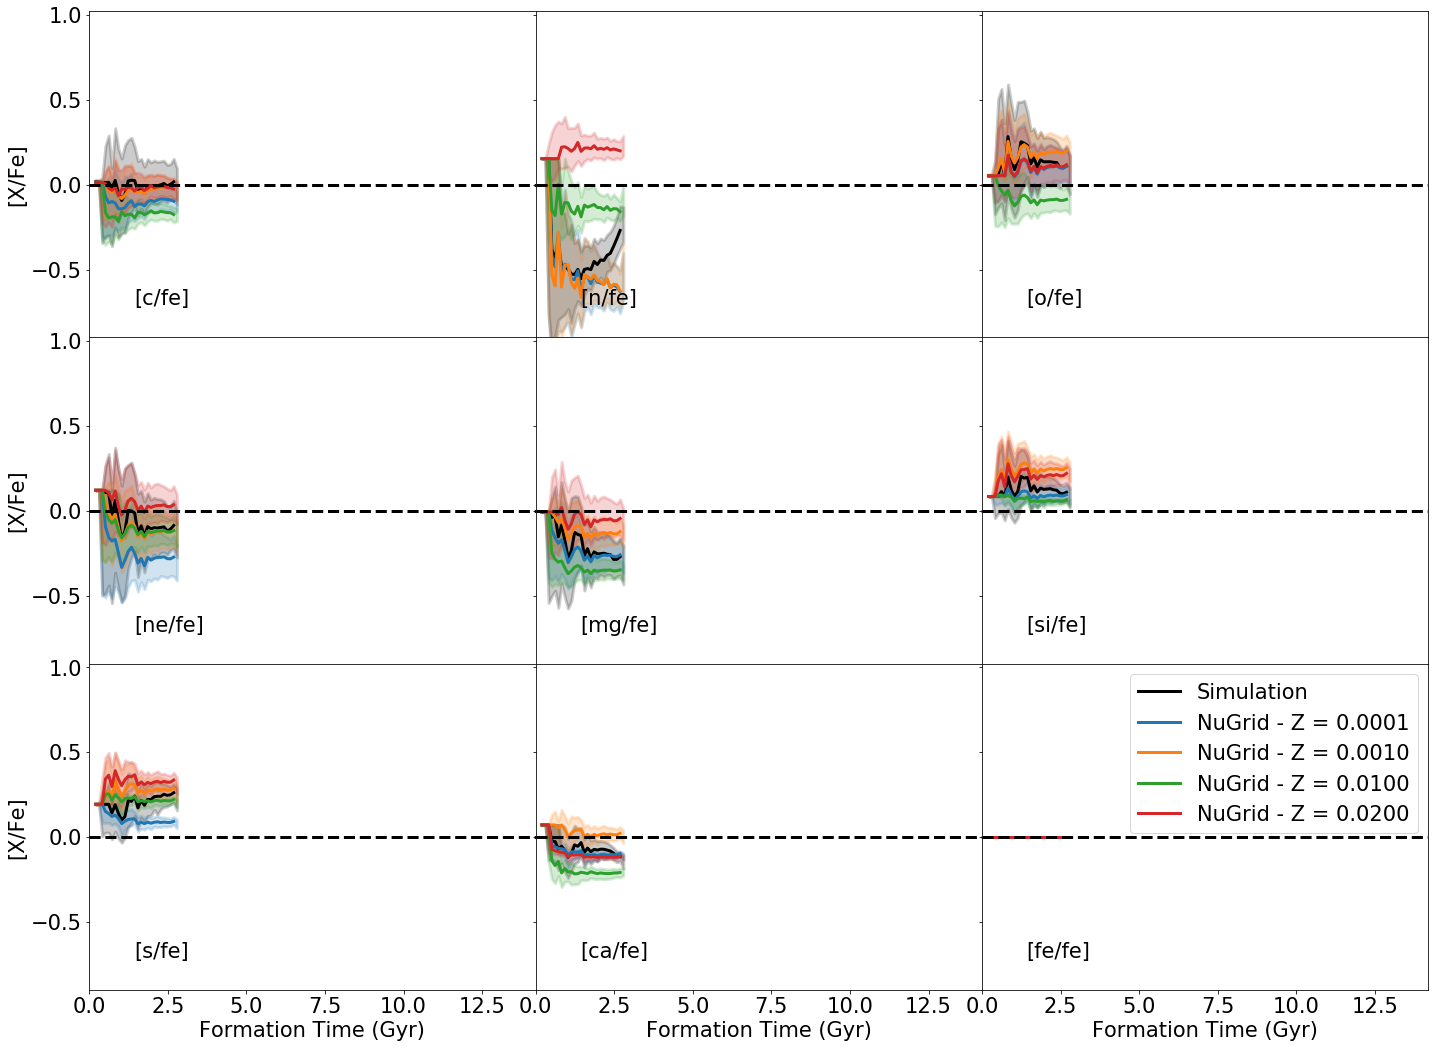

In [4]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax,part['star'].prop('form.time'),
                     get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, part['star'].prop('form.time'), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(0,14.2)
        ax.set_ylim(-0.9,1.02)


        xy = (0.1,0.1)
        ax.annotate(r"[" + ye1 + "/" + ye2 +"]", xy, xy, xycoords='axes fraction')
                    
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')

        if count > 5:
            ax.set_xlabel(r"Formation Time (Gyr)")
        count = count + 1

all_ax[(2,2)].legend(loc='best')

for i in np.arange(3):
    all_ax[(i,0)].set_ylabel("[X/Fe]")

fig.savefig(outdir + "NuGrid_postprocessing_age.png", bbox_inches = 'tight',
    pad_inches = 0.0)

Plotting [c/fe] for all models
Plotting [n/fe] for all models


/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/aemerick/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


Plotting [o/fe] for all models
Plotting [ne/fe] for all models
Plotting [mg/fe] for all models
Plotting [si/fe] for all models
Plotting [s/fe] for all models
Plotting [ca/fe] for all models
Plotting [fe/fe] for all models


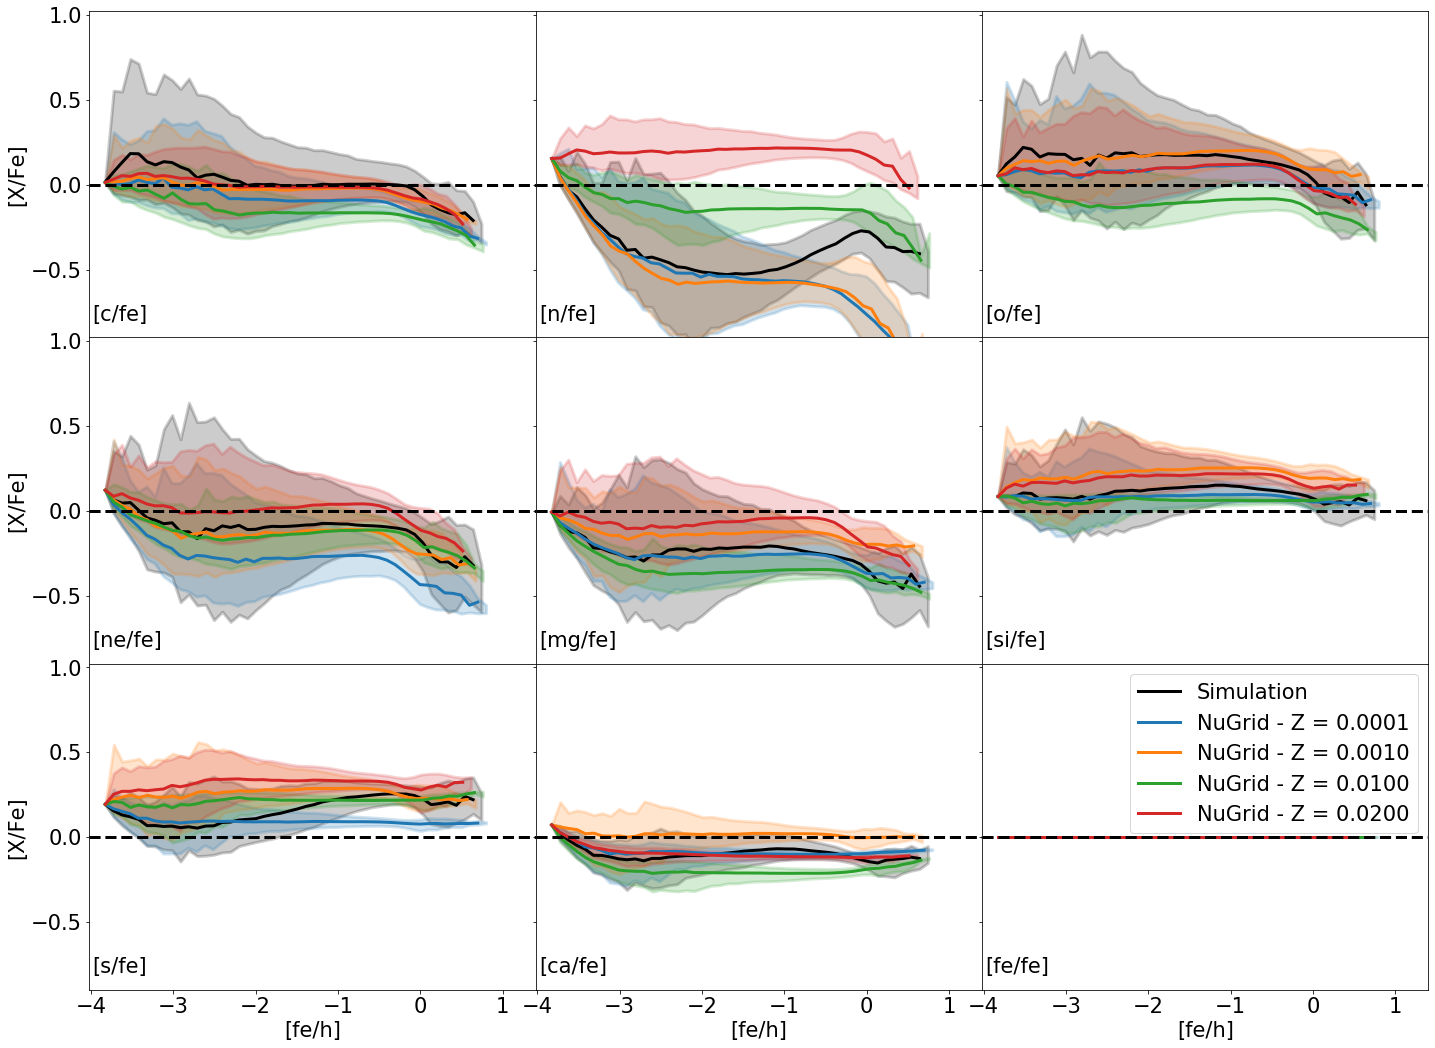

In [5]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.8
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')

        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

for i in np.arange(3):
    all_ax[(i,0)].set_ylabel("[X/Fe]")        
        
all_ax[(2,2)].legend(loc='best')
fig.savefig(outdir + "NuGrid_postprocessing_test_fe_h.png",bbox_inches = 'tight',
    pad_inches = 0.0)

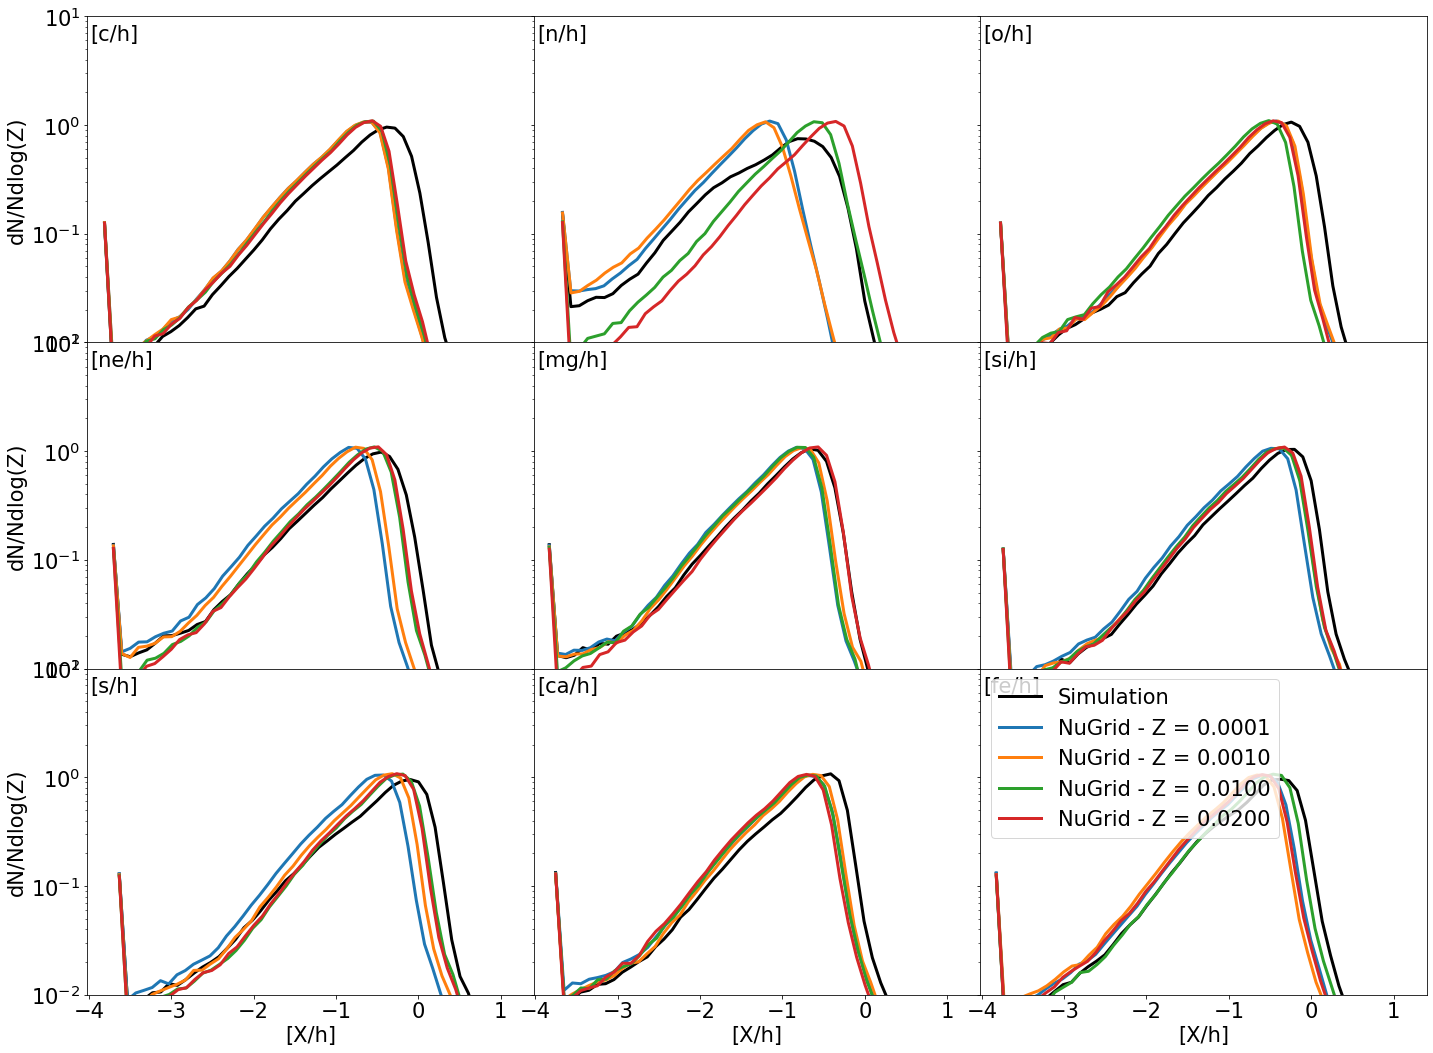

In [6]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

xe1,xe2 = 'xxx','h'

x_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        xe1 = x_elements[count]        
    
        mdf_plot(ax, get_abundance(part['star'],xe1,xe2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            mdf_plot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(0.01,10.0)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = 6.
        ax.text(x,y,r"[" + xe1 + "/" + xe2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        ax.semilogy()
        
        
        if count > 5:
            ax.set_xlabel(r"[X/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel('dN/Ndlog(Z)')

all_ax[(2,2)].legend(loc='best')
fig.savefig(outdir + "NuGrid_postprocessing_MDF.png",bbox_inches = 'tight',
    pad_inches = 0.0)

Plotting [c/fe] for all models
Plotting [n/fe] for all models
Plotting [o/fe] for all models
Plotting [ne/fe] for all models
Plotting [mg/fe] for all models
Plotting [si/fe] for all models
Plotting [s/fe] for all models
Plotting [ca/fe] for all models
Plotting [fe/fe] for all models


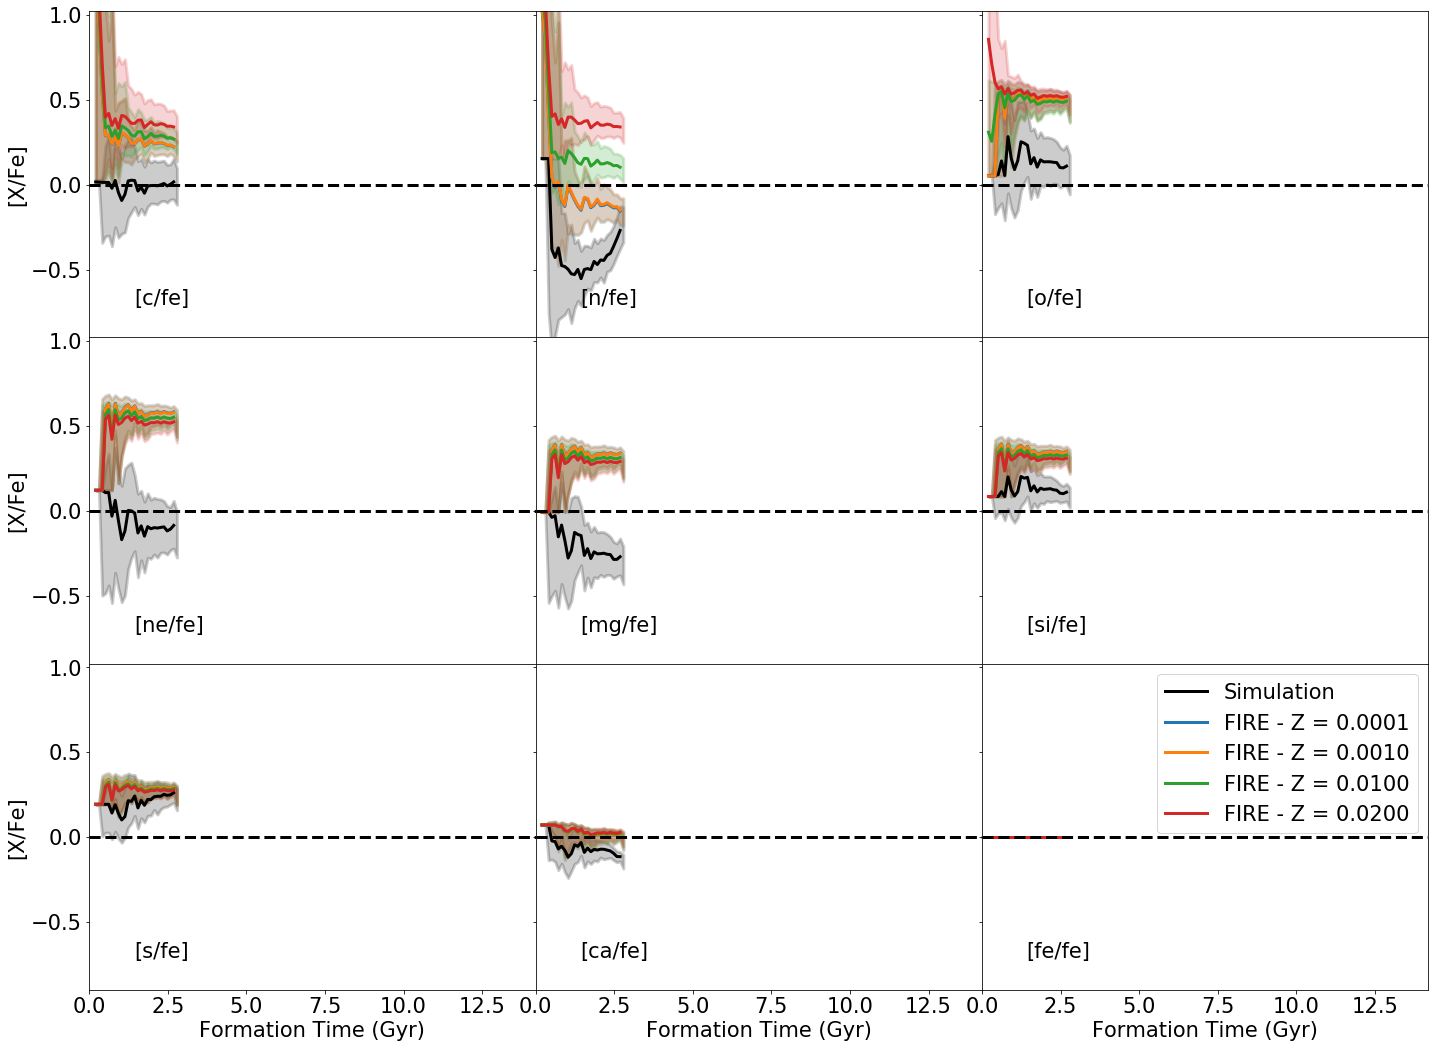

In [7]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax,part['star'].prop('form.time'),
                     get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, part['star'].prop('form.time'), 
                         get_abundance(fire_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="FIRE - Z = %4.4f"%(z))
            

        ax.set_xlim(0,14.2)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        xy = (0.1,0.1)
        ax.annotate(r"[" + ye1 + "/" + ye2 +"]", xy, xy, xycoords='axes fraction')
                    
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')

        if count > 5:
            ax.set_xlabel(r"Formation Time (Gyr)")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel("[X/Fe]")        

all_ax[(2,2)].legend(loc='best')
fig.savefig(outdir + "FIRE_postprocessing_age.png",bbox_inches = 'tight',
    pad_inches = 0.0)

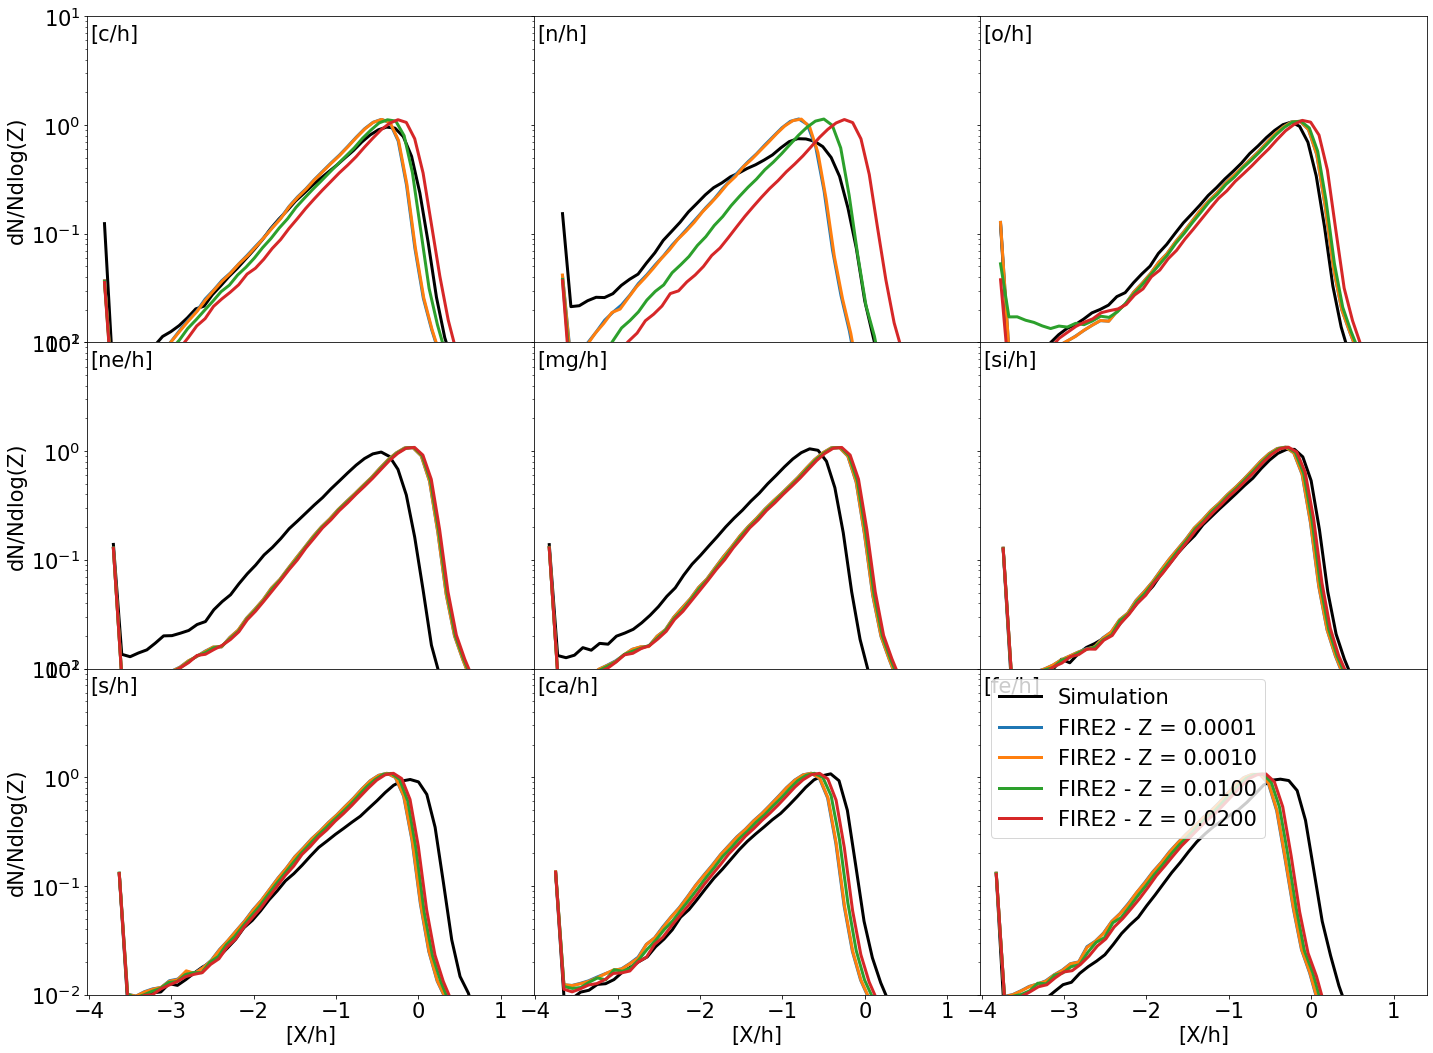

In [8]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

xe1,xe2 = 'xxx','h'

x_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        xe1 = x_elements[count]        
    
        mdf_plot(ax, get_abundance(part['star'],xe1,xe2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            mdf_plot(ax, get_abundance(fire_part[z]['star'],xe1,xe2,True), 
                         color = 'C%i'%(i), label="FIRE2 - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(0.01,10.0)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = 6.
        ax.text(x,y,r"[" + xe1 + "/" + xe2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        ax.semilogy()
        
        
        if count > 5:
            ax.set_xlabel(r"[X/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel('dN/Ndlog(Z)')

all_ax[(2,2)].legend(loc='best')
fig.savefig(outdir + "FIRE2_postprocessing_MDF.png",bbox_inches = 'tight',
    pad_inches = 0.0)

Plotting [c/fe] for all models
Plotting [n/fe] for all models
Plotting [o/fe] for all models
Plotting [ne/fe] for all models
Plotting [mg/fe] for all models
Plotting [si/fe] for all models
Plotting [s/fe] for all models
Plotting [ca/fe] for all models
Plotting [fe/fe] for all models


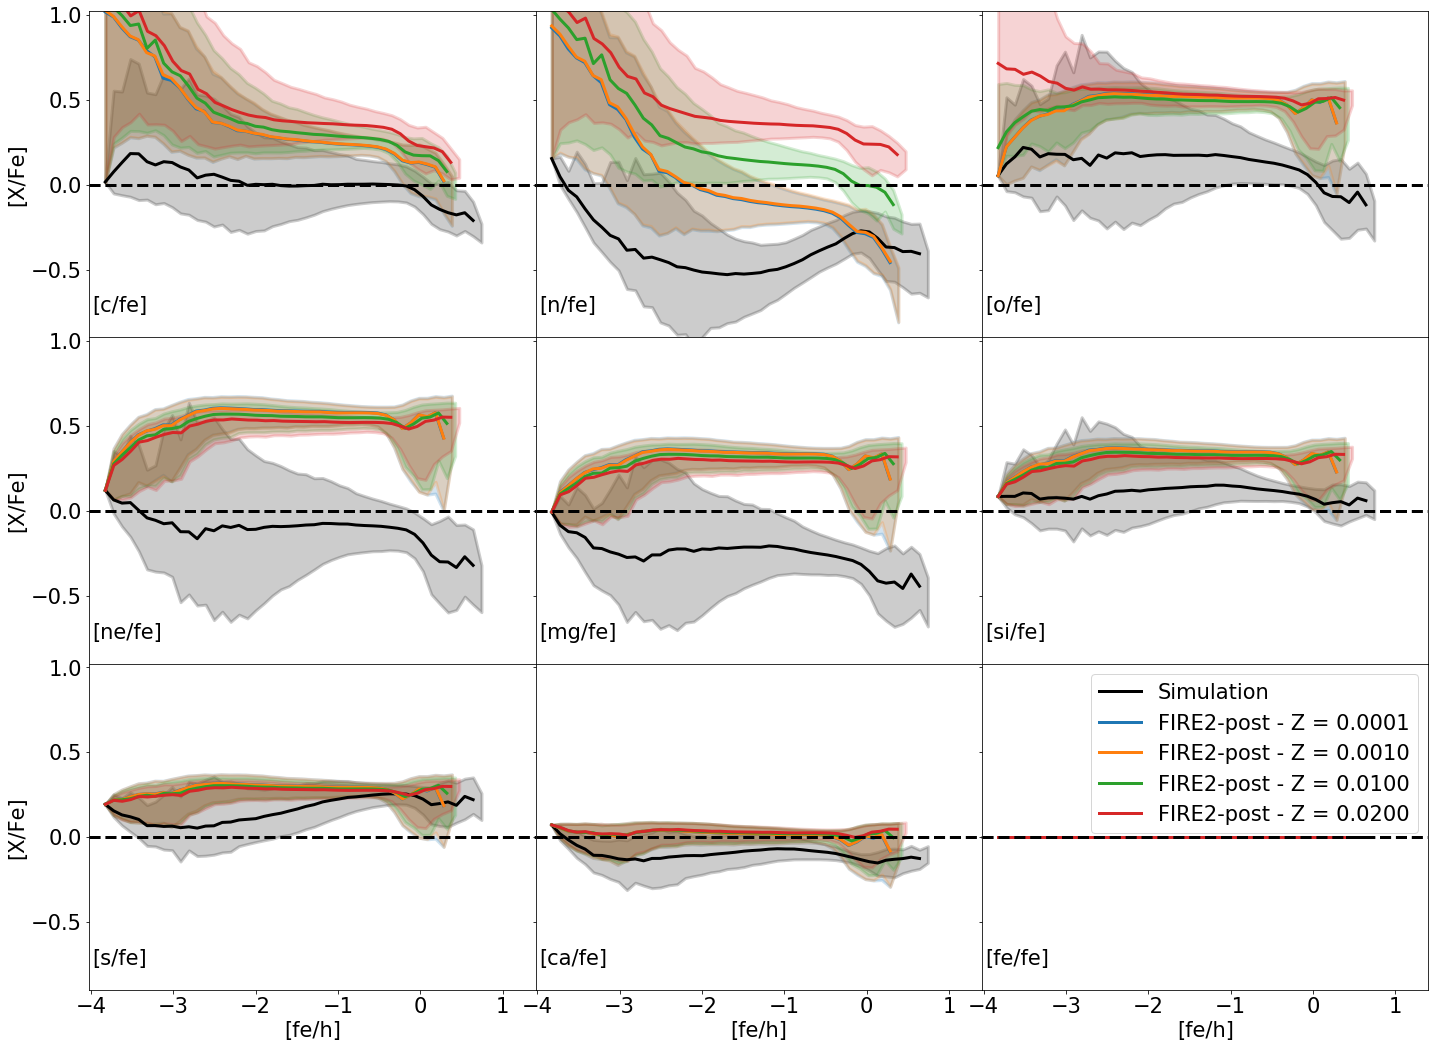

In [9]:

#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(fire_part[z]['star'],xe1,xe2,True), 
                         get_abundance(fire_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="FIRE2-post - Z = %4.4f"%(z))

            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.75
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        
        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel("[X/Fe]")        

all_ax[(2,2)].legend(loc='best')    
fig.savefig(outdir + "FIRE2_postprocessing_test_Fe_h.png",bbox_inches = 'tight',
    pad_inches = 0.0)

Plotting [c/s] for all models
Plotting [n/s] for all models
Plotting [o/s] for all models
Plotting [ne/s] for all models
Plotting [mg/s] for all models
Plotting [si/s] for all models
Plotting [s/s] for all models
Plotting [ca/s] for all models
Plotting [fe/s] for all models


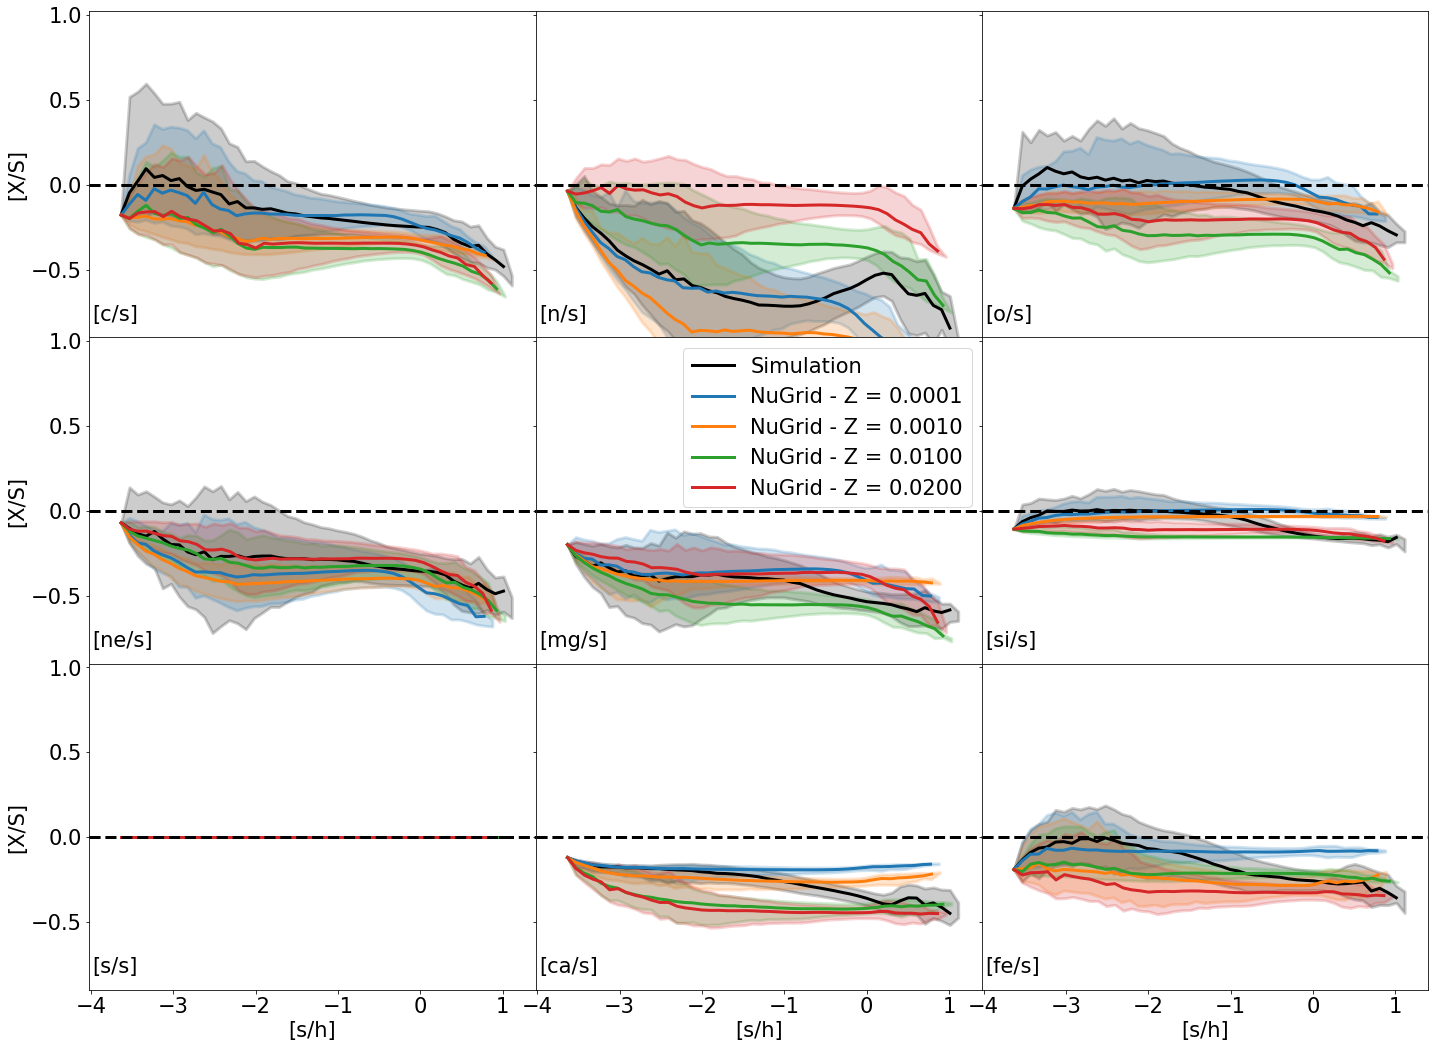

In [10]:
#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','s'
xe1,xe2 = 's','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid - Z = %4.4f"%(z))
            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.8
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')

        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel("[X/S]")        

all_ax[(1,1)].legend(loc='best')
fig.savefig(outdir + "NuGrid_postprocessing_test_s_h.png",bbox_inches = 'tight',
    pad_inches = 0.0)

Plotting [c/s] for all models
Plotting [n/s] for all models
Plotting [o/s] for all models
Plotting [ne/s] for all models
Plotting [mg/s] for all models
Plotting [si/s] for all models
Plotting [s/s] for all models
Plotting [ca/s] for all models
Plotting [fe/s] for all models


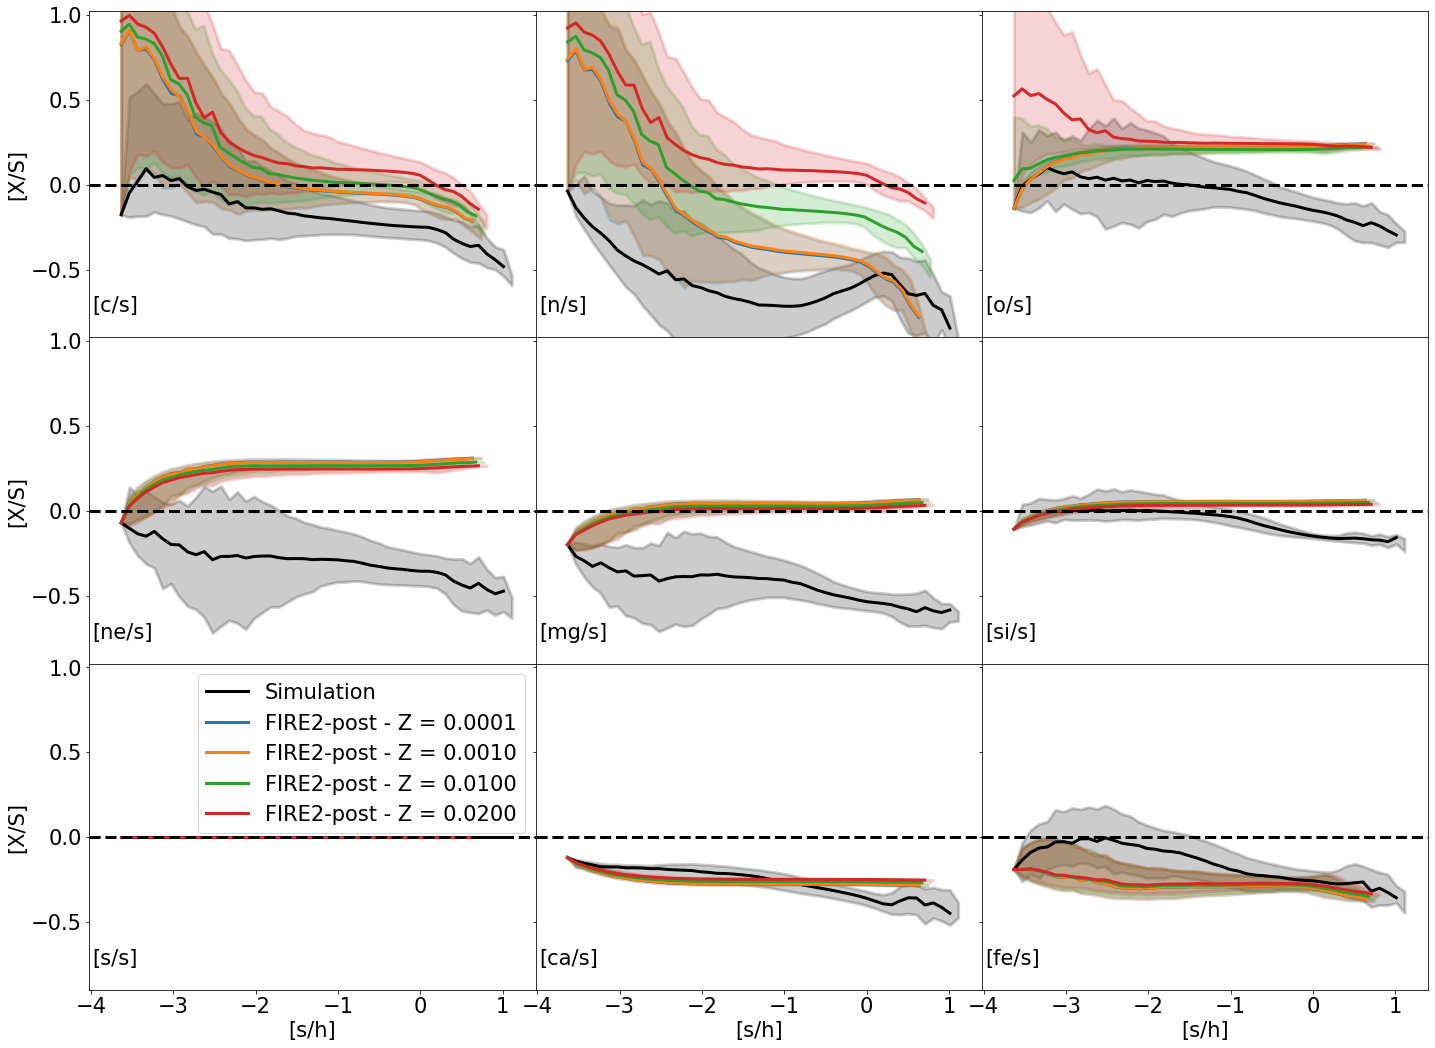

In [11]:

#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(3,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*3)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','s'
xe1,xe2 = 's','h'

y_elements = ['c','n','o','ne','mg','si','s','ca','fe']

count = 0
for ax2 in all_ax:
    for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
                 color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(fire_part[z]['star'],xe1,xe2,True), 
                         get_abundance(fire_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="FIRE2-post - Z = %4.4f"%(z))

            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-0.9,1.02)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -0.75
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        
        if count > 5:
            ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1
        
for i in np.arange(3):
    all_ax[(i,0)].set_ylabel("[X/S]")  
    
all_ax[(2,0)].legend(loc='best')    
fig.savefig(outdir + "FIRE2_postprocessing_test_s_h.png",bbox_inches = 'tight',
    pad_inches = 0.0)

Plotting [ba/fe] for all models
Plotting [sr/fe] for all models
Plotting [y/fe] for all models


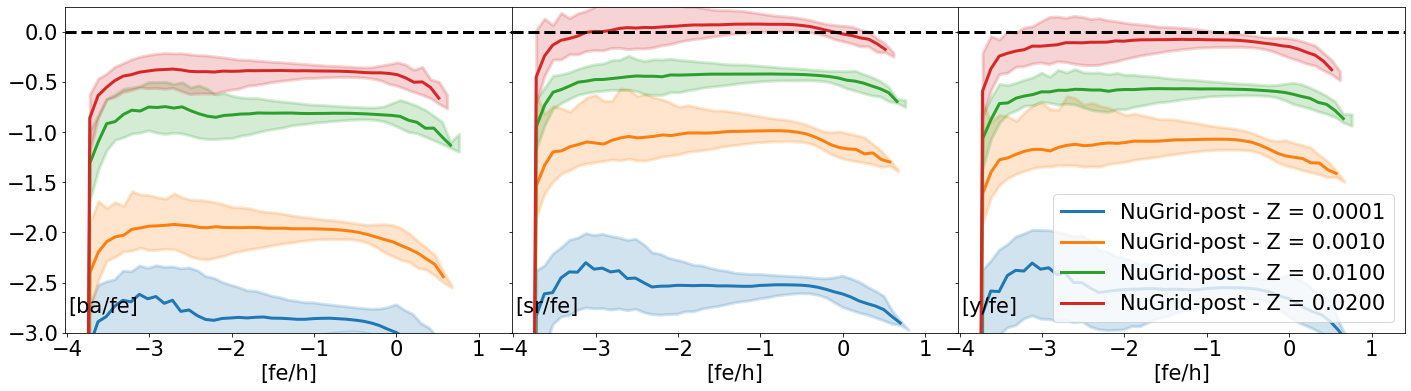

In [15]:

#
#
# lets make a cool plot
#
#
plot_settings()

fig, all_ax = plt.subplots(1,3,sharex=True,sharey=True)
fig.set_size_inches(8*3,6*1)

fig.subplots_adjust(wspace=0,hspace=0)

ye1,ye2 = 'XXX','fe'
xe1,xe2 = 'fe','h'

y_elements = ['ba','sr','y']

count = 0
for ax in all_ax:
    #for ax in ax2:
        
        ye1 = y_elements[count]
        
        print("Plotting [" + ye1 + "/" + ye2 + "] for all models")
        
    
        #lineplot(ax, get_abundance(part['star'],xe1,xe2), get_abundance(part['star'],ye1,ye2),
        #         color = 'black', label="Simulation")
        
        for i,z in enumerate([0.0001,0.001,0.01,0.02]):
            lineplot(ax, get_abundance(nugrid_part[z]['star'],xe1,xe2,True), 
                         get_abundance(nugrid_part[z]['star'],ye1,ye2,True),
                         color = 'C%i'%(i), label="NuGrid-post - Z = %4.4f"%(z))

            

        ax.set_xlim(-4.02,1.4)
        ax.set_ylim(-3,0.25)

        #ax.set_ylabel(r"[" + ye1 + "/" + ye2 +"]")
        x = -3.98
        y = -2.8
        ax.text(x,y,r"[" + ye1 + "/" + ye2 +"]")
        
        ax.plot(ax.get_xlim(),[0.0,0.0],lw=3,color='black',ls='--')
        
        ax.set_xlabel(r"[" + xe1 + "/" + xe2 +"]")
        count = count + 1

all_ax[2].legend(loc='best')    
fig.savefig(outdir + "NuGrid_postprocessing_test_sproc.png",bbox_inches = 'tight',
    pad_inches = 0.0)

In [13]:
get_abundance(fire_part[0.0001]['star'],'s','h',True)

array([-3.68180073, -3.68180073, -0.39328311, ..., -1.68413529,
       -1.42678487, -1.8496715 ])